In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import json
import yaml
from pathlib import Path

%matplotlib inline
sns.set()

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-05-16 18:11:27.218772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from mlrl.eval.procgen_baseline_meta import test_policies_with_pretrained_model
from mlrl.eval.procgen_rlts import load_best_meta_policy
from mlrl.utils.wandb_utils import get_wandb_info_from_run_dir

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


pygame 2.1.3 (SDL 2.0.22, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using TensorFlow 2.12.0


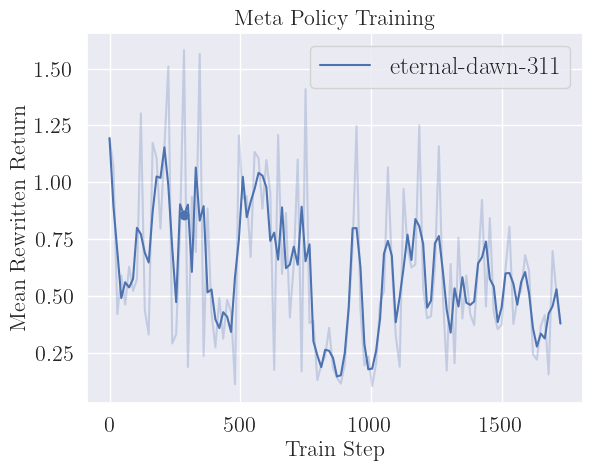

In [36]:
run_path = Path('outputs/runs/ppo_run_2023-05-15-06-57-08/')

run = get_wandb_info_from_run_dir(run_path)
load_best_meta_policy(run, selection_method='best')

In [39]:
run['config']['max_cost_of_computation']

0.05

In [42]:
policy = run['best_policy']
run_args = run['run_args']
computational_cost = 0.1
run_args['random_cost_of_computation'] = False
run_args['cost_of_computation'] = computational_cost
results_accumulator, mean_results = test_policies_with_pretrained_model({'RLTS': lambda _: policy},
                                                                        n_envs=2,
                                                                        n_object_level_episodes=2,
                                                                        args=run_args,
                                                                        max_object_level_steps=10)

Evaluating RLTS
2/2 [==============================] - 13s 54ms/episode - ObjectLevelMeanReward: 3.0000 - ObjectLevelMeanStepsPerEpisode: 10.0000 - ObjectLevelEpisodes: 2.0000 - ObjectLevelCurrentEpisodeReturn: 0.0000e+00 - ObjectLevelCurrentEpisodeSteps: 0.0000e+00 - MeanTotalComputationalCost: 0.0167 - MeanTotalComputations: 1.0606


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [429]:
meta_policy_model_paths = [
    Path('outputs/runs/ppo_run_2023-05-15-06-57-08/'),
]

In [430]:
def clean_config(config: dict) -> dict:
    return {
        k: v['value'] if isinstance(v, dict) and 'value' in v else v
        for k, v in config.items()
    }

In [431]:
import wandb
api = wandb.Api()

In [432]:
runs = []


for model_dir in meta_policy_model_paths:
    for wandb_path in Path('wandb').glob('run-*'):
        config_path = wandb_path / 'files/config.yaml'
        
        if not config_path.exists():
            continue
        
        with open(config_path) as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        
        if config.get('root_dir', dict(value=None))['value'] == str(model_dir) + '/':
            config = clean_config(config)
            run_id = wandb_path.name.split('-')[-1]
            run = api.run("drcope/mlrl/" + run_id)
            runs.append({
                'run_id': run_id,
                'run': run,
                'wandb_path': wandb_path,
                'model_dir': model_dir,
                'config': config,
                'history': run.history()
            })
            break

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


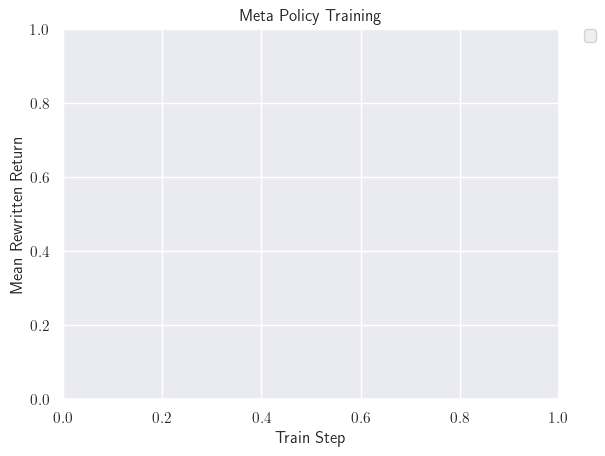

In [433]:
fig, ax = plt.subplots()
for run in runs:
    wanbd_run = run['run']
    df = run['history']
    df.sort_values(by='TrainStep', inplace=True)
    df = df[df['EvalRewrittenAverageReturn'].isna() == False]
    y = df['EvalRewrittenAverageReturn'].array
    y_smooth = np.concatenate([[y[0]], np.convolve(y, np.ones(3)/3, mode='valid'), [y[-1]]])

    x = df['TrainStep'].array
    xs = list(x)
    best_model_epoch = max(xs, key=lambda i: y_smooth[xs.index(i)])
    run['best_model_epoch'] = best_model_epoch

    line, *_ = ax.plot(x, y, alpha=0.25)
    ax.plot(df['TrainStep'], y_smooth, label=wanbd_run.name, color=line.get_color())
    ax.scatter(best_model_epoch, y_smooth[xs.index(best_model_epoch)], color=line.get_color())

# legend outside plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('Train Step')
ax.set_ylabel('Mean Rewritten Return')
ax.set_title('Meta Policy Training')
plt.show()

In [434]:
import tf_agents
import tensorflow as tf


def load_policy(env, args, ckpt_dir: str = None):

    agent = create_search_ppo_agent(env, args)
    policy = agent.policy

    checkpoint = tf.train.Checkpoint(policy=policy)

    if ckpt_dir:
        file_prefix = os.path.join(ckpt_dir,
                                   tf.saved_model.VARIABLES_DIRECTORY,
                                   tf.saved_model.VARIABLES_FILENAME)

        print(f'Loading checkpoint from {file_prefix}')
        checkpoint.read(file_prefix)

    return policy


for run in runs:
    best_epoch = run['best_model_epoch']

    saved_model_path = run['model_dir'] / 'policies/ckpt/policy'
    ckpt_dir = run['model_dir'] / f'policies/ckpt/checkpoints/policy_checkpoint_{best_epoch:010d}'
    # ckpt_dir = run['model_dir'] / f'policies/best/greedy_policy'

    from mlrl.train.procgen_meta import create_batched_procgen_meta_envs, load_pretrained_q_network

    exclude_keys = ['learning_rate', 'name']
    run_args = {
        k: v for k, v in run['config'].items()
        if k not in exclude_keys
    }

    run['run_args'] = run_args

    object_config = load_pretrained_q_network(
        folder=run_args['pretrained_runs_folder'],
        run=run_args['pretrained_run'],
        percentile=run_args.get('pretrained_percentile', 0.75),
        verbose=False
    )

    batched_meta_env = create_batched_procgen_meta_envs(
        1, run_args['object_level_config'], **run_args
    )

    # from tf_agents.policies.policy_loader import load
    # run['best_policy'] = load(saved_model_path, ckpt_dir)
    run['best_policy'] = load_policy(batched_meta_env, run_args, ckpt_dir)
    # run['best_policy'] = tf.compat.v2.saved_model.load(str(saved_model_path))

    # from tf_agents.policies import py_tf_eager_policy
    # run['best_policy'] = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    #         saved_model_path, batched_meta_env.time_step_spec(), batched_meta_env.action_spec())

In [36]:
# for run in runs:

#     run_args = run['run_args']

#     load_pretrained_q_network(
#         folder=run_args['pretrained_runs_folder'],
#         run=run_args['pretrained_run'],
#         percentile=run_args.get('pretrained_percentile', 0.75),
#     )

#     eval_runner = EvalRunner(eval_env=run['env'],
#                              policy=run['best_policy'],
#                              eval_steps=1024 * 8,
#                              rewrite_rewards=True,
#                              convert_to_eager=False)

#     run['eval_metrics'] = eval_runner.run()

<Axes: >

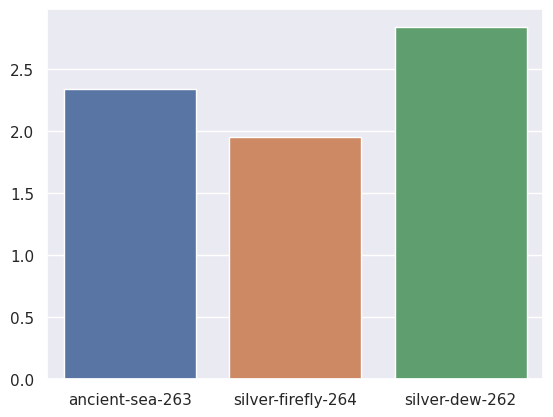

In [127]:
sns.barplot(x=[run['run'].name for run in runs],
            y=[run['eval_metrics']['EvalRewrittenAverageReturn'] for run in runs])

<Axes: >

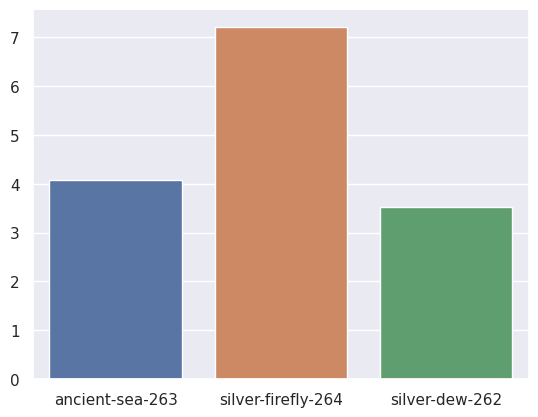

In [138]:
sns.barplot(x=[run['run'].name for run in runs],
            y=[run['eval_metrics']['EvalAverageEpisodeLength'] for run in runs])

In [98]:
run = runs[0]
run_args = run['run_args']


object_config = load_pretrained_q_network(
    folder=run_args['pretrained_runs_folder'],
    run=run_args['pretrained_run'],
    percentile=run_args.get('pretrained_percentile', 0.75),
    verbose=False
)

from mlrl.runners.eval_runner import EvalRunner


batched_meta_env = create_batched_procgen_meta_envs(
    n_envs=2,
    object_config=object_config,
    **run_args
)

eval_runner = EvalRunner(eval_env=batched_meta_env,
                         policy=run['best_policy'],
                         eval_steps=1024 * 8,
                         convert_to_eager=False,
                         rewrite_rewards=True)


In [99]:
from mlrl.utils.render_utils import embed_mp4

embed_mp4(eval_runner.create_policy_eval_video(10))

In [12]:
from mlrl.experiments.procgen_baseline_meta import test_policies_with_pretrained_model, ResultsAccumulator
from mlrl.utils import time_id

Writing results to tmp/outputs/eval/procgen/18-19-01-02-05-2023
Evaluating Learned Meta-Policy Trained at Percentile 0.5
2/2 [==============================] - 118s 110ms/episode - ObjectLevelMeanReward: 21.0000 - ObjectLevelMeanStepsPerEpisode: 101.0000 - ObjectLevelEpisodes: 2.0000
Evaluation stats:
EvalTime: 117.646


[{'Meta-level Policy': 'Learned Meta-Policy Trained at Percentile 0.5',
  'wandb_version': 1,
  '_wandb': {'cli_version': '0.12.10',
   'framework': 'keras',
   'is_jupyter_run': False,
   'is_kaggle_kernel': False,
   'python_version': '3.8.10',
   'start_time': 1682916582,
   't': {1: [2, 3], 3: [16], 4: '3.8.10', 5: '0.12.10', 8: [5]}},
  'agent': 'ppo',
  'collect_steps': 4096,
  'computational_rewards': True,
  'env_batch_size': 64,
  'eval_interval': 15,
  'eval_steps': 1000,
  'expand_all_actions': True,
  'finish_on_terminate': True,
  'gpus': None,
  'max_cost_of_computation': 0.002,
  'max_tree_size': 64,
  'meta_discount': 0.99,
  'meta_time_limit': 500,
  'min_train_computation_steps': 5,
  'n_collect_envs': 64,
  'n_eval_envs': 64,
  'n_lstm_layers': 0,
  'n_video_envs': 12,
  'num_iterations': 2000,
  'num_learn_samples': 10,
  'object_discount': 0.99,
  'object_level_config': {'action_repeats': 4,
   'agent_name': 'categorical_dqn_agent',
   'collect_steps_per_iteration'

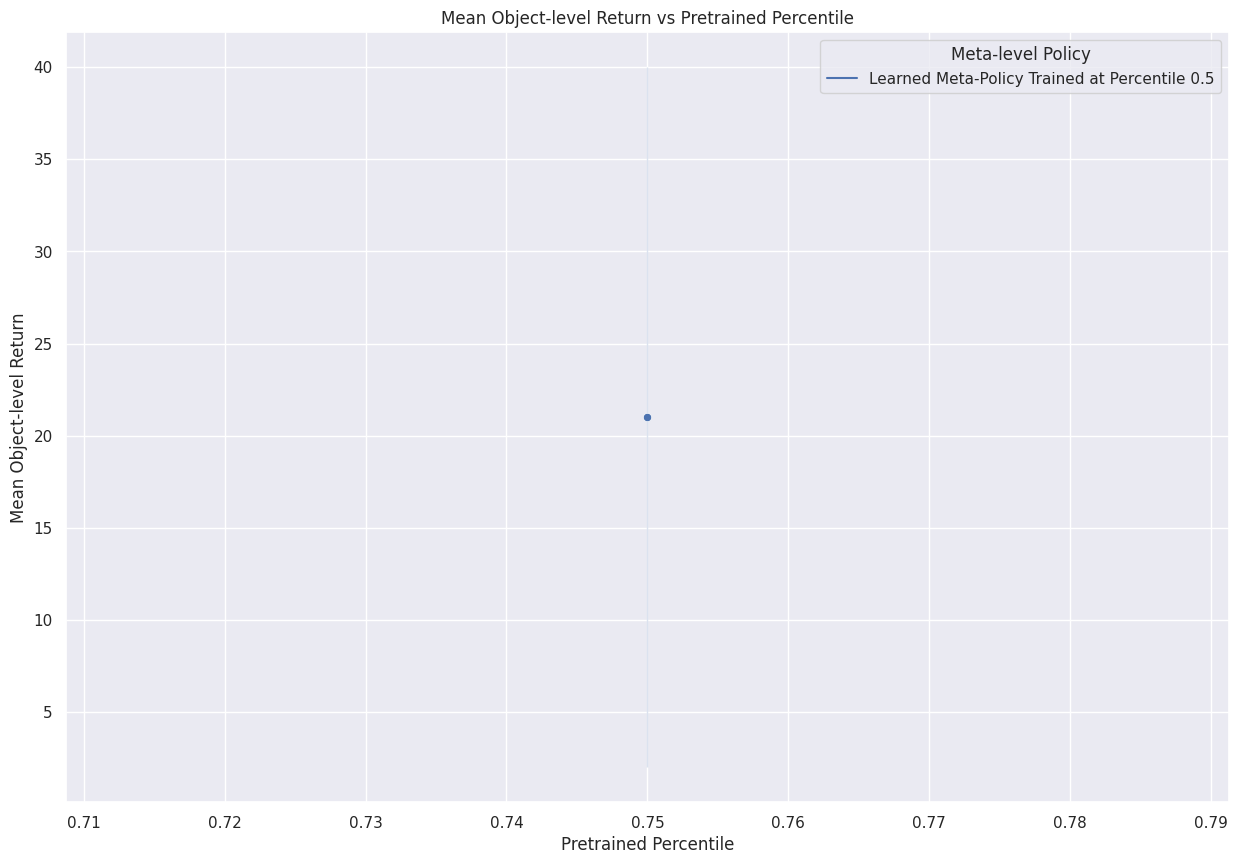

In [133]:
run = runs[0]

percentile = run['config']['pretrained_percentile']
policy_creators = {
    f'Learned Meta-Policy Trained at Percentile {percentile}': lambda _: run['best_policy']
}
output_dir = Path('tmp/outputs/eval/procgen') / time_id()
print(f'Writing results to {output_dir}')

results_accumulator = ResultsAccumulator(output_dir=output_dir)
exclude_keys = ['learning_rate', 'name']
run_args = {
    k: v for k, v in run['config'].items()
    if k not in exclude_keys
}

test_policies_with_pretrained_model(policy_creators,
                                    percentile=percentile,
                                    args=run_args,
                                    outputs_dir=output_dir,
                                    results_observer=results_accumulator,
                                    max_object_level_steps=500,
                                    n_object_level_episodes=2)